In [1]:
import re
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

In [2]:
df = pd.read_csv('../data/metadata_with_tag.csv',
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str})

In [3]:
df_covid = df[df.tag_disease_covid19]

# Preprocessing

In [4]:
df['authors_list'] = df.authors.str.split(";")

In [5]:
author_papers = df.explode('authors_list')[['authors_list','sha']]
author_papers.columns = ['author_name','sha']
author_papers = author_papers.dropna()

In [6]:
author_papers.head(10)

,author_name,sha
0,"Madani, Tariq A",d1aafb70c066a2068b02786f8929fd9c900897fb
0,"Al-Ghamdi, Aisha A",d1aafb70c066a2068b02786f8929fd9c900897fb
1,"Vliet, Albert van der",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Eiserich, Jason P",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Cross, Carroll E",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
2,"Crouch, Erika C",06ced00a5fc04215949aa72528f2eeaae1d58927
3,"Fagan, Karen A",348055649b6b8cf2b9a376498df9bf41f7123605
3,"McMurtry, Ivan F",348055649b6b8cf2b9a376498df9bf41f7123605
3,"Rodman, David M",348055649b6b8cf2b9a376498df9bf41f7123605
4,"Domachowske, Joseph B",5f48792a5fa08bed9f56016f4981ae2ca6031b32


## Generalize Names

In [7]:
author_papers['author_name'] = author_papers['author_name'].str.replace(" ", "").str.replace(".","").str.replace(',',', ')

In [8]:
from mlxtend.text import generalize_names

In [77]:
unqiue_count =[]
for letters in range(1,20,2):
    unqiue_count.append(
        len(
            author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=letters))
            .unique()))

/Users/billy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


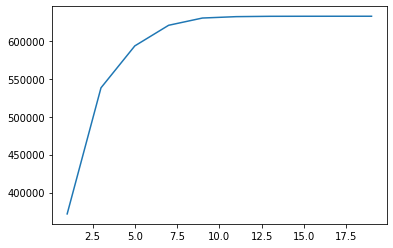

In [78]:
sns.lineplot(list( range(1,20,2)), unqiue_count)

In [9]:
author_papers['author_name'] = author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=5))

In [10]:
author_papers['author_name'].str.len().describe(percentiles=[.85,.9,.95,0.99,0.995,0.999,0.9995])

count     1.218020e+06
mean      1.094845e+01
std       3.585698e+00
min       0.000000e+00
50%       1.100000e+01
85%       1.400000e+01
90%       1.500000e+01
95%       1.700000e+01
99%       2.100000e+01
99.5%     2.200000e+01
99.9%     2.500000e+01
99.95%    2.600000e+01
max       9.800000e+01
Name: author_name, dtype: float64

In [12]:
author_papers = author_papers[(author_papers['author_name'].str.len() <= 25) 
                              & (author_papers['author_name'].str.len() > 0) 
                              & (author_papers['sha'] != False)
                              & (author_papers['author_name'] != 'false')]

author_papers['author_name'] = author_papers['author_name'].apply(lambda x:x.title())
author_papers.to_csv('../data/author_papers.csv',index=False)

In [14]:
covid_paper = list(df_covid.sha.unique())
covid_author_paper = author_papers[author_papers.sha.isin(covid_paper)][['author_name','sha']]

# EDA

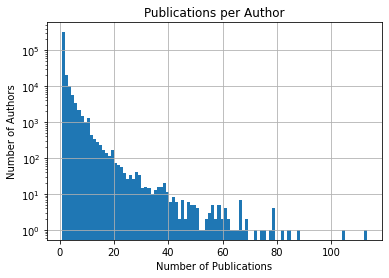

In [16]:
plt.title('Publications per Author')
plt.xlabel('Number of Publications')
plt.ylabel('Number of Authors')
covid_author_paper.groupby('author_name')['sha'].count().hist(bins=100,log=True)

In [198]:
covid_author_paper.groupby('author_name')['sha'].count().describe(percentiles=[0.75,0.9,0.95,0.99])

count    365136.000000
mean          1.701673
std           2.107762
min           1.000000
50%           1.000000
75%           2.000000
90%           3.000000
95%           4.000000
99%          10.000000
max         113.000000
Name: sha, dtype: float64

In [20]:
len(covid_author_paper.author_name.unique())

365136

In [199]:
author_paper_cnt = covid_author_paper.groupby('author_name')['sha'].count()
author_paper_cnt.name = 'paper_count'
filtered_author_index = author_paper_cnt[author_paper_cnt > 2].index.to_list()
len(filtered_author_index)

48259

In [200]:
filtered_author_papers = covid_author_paper[covid_author_paper['author_name'].isin(filtered_author_index)]

# Build Network

In [202]:
paper_dict = dict(enumerate(list(filtered_author_papers['sha'].unique())))
paper_dict = {v:k for k,v in paper_dict.items()}

In [203]:
author_dict = dict(enumerate(list(filtered_author_papers['author_name'].unique())))
author_dict = {v:k for k,v in author_dict.items()}

In [204]:
author_paper_tuple = list(zip(filtered_author_papers['author_name'], filtered_author_papers['sha']))

In [205]:
author_paper_tuple = [(author_dict[author], paper_dict[paper])for author, paper in author_paper_tuple]

In [206]:
from scipy.sparse import csc_matrix,lil_matrix

In [207]:
#AP[i,j] = 1 indicates that author i published paper j
AP = csc_matrix((np.ones(len(author_paper_tuple)), zip(*author_paper_tuple)))
##AA[i,j] = 1 indicates that author i published a paper with author j
AA = AP.dot(AP.T)

In [208]:
AA

<48259x48259 sparse matrix of type '<class 'numpy.float64'>'
	with 1354133 stored elements in Compressed Sparse Column format>

In [209]:
AA = AA.tolil()
AA.setdiag(0)

In [210]:
AA

<48259x48259 sparse matrix of type '<class 'numpy.float64'>'
	with 1305874 stored elements in List of Lists format>

In [211]:
#construct graph
G = nx.convert_matrix.from_scipy_sparse_matrix(AA)

# Network Analysis

In [212]:
degree = nx.degree(G)
degree_centrality = nx.degree_centrality(G)
#betweenness_centrality = nx.betweenness_centrality(G)

In [213]:
df_author = pd.DataFrame(author_dict.items())
df_author.columns= ['name','id']

In [214]:
df_author['degree'] = df_author['id'].apply(lambda x:degree[x])
df_author['degree_centrality'] = df_author['id'].apply(lambda x:degree_centrality[x])
#df_author['betweenness_centrality'] = df_author['id'].apply(lambda x:betweenness_centrality[x])

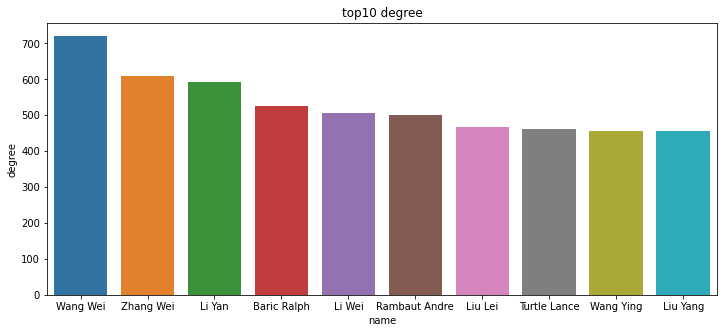

In [215]:
plt.figure(figsize=(12, 5))
plt.title('top10 degree')
sns.barplot(data=df_author.sort_values('degree',ascending=False)[:10], 
            x='name', y='degree')


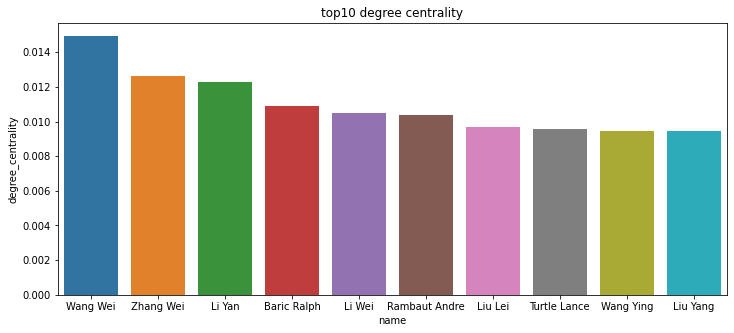

In [292]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('degree_centrality',ascending=False)[:10], 
            x='name', y='degree_centrality')

# Community Detection

In [217]:
import community as community_louvain

In [218]:
partition = community_louvain.best_partition(G)

In [219]:
df_author['partition'] = df_author['id'].apply(lambda x:partition[x])

In [222]:
dendro = community_louvain.generate_dendrogram(G)

In [231]:
df_author = pd.merge(left=df_author, right= author_paper_cnt,how='left',left_on='name',right_on='author_name')
df_author_sampled = df_author[df_author.paper_count >= 10]
sampled_id = df_author_sampled.id.to_list()

In [287]:
top10_community = list(df_author.groupby(partition).id.count().sort_values(ascending=False)[:10].index)

In [291]:
df_author[
    df_author.partition.isin(top10_community)].groupby(partition).apply(
    lambda x: x.nlargest(5, 'paper_count'))

name     id  degree  degree_centrality  \
1   610                  Wang Wei    610     721           0.014941   
    829                 Zhang Wei    829     610           0.012640   
    217                   Liu Lei    217     468           0.009698   
    776                    Li Wei    776     505           0.010465   
    214                 Yang Yang    214     404           0.008372   
2   8359                 Zhang Yu   8359     357           0.007398   
    10469       Yazdanpanah Yazda  10469     159           0.003295   
    17580              Lina Bruno  17580     158           0.003274   
    1437               Zhang Qian   1437     221           0.004580   
    5293       Hatziioannou Theod   5293     115           0.002383   
4   6041                  Zhang Y   6041     346           0.007170   
    4611                   Wang Y   4611     327           0.006776   
    9699                     Li Y   9699     374           0.007750   
    4456                    Liu Y   4456     295           0.006113   
    5094                   Wang X   5094     291           0.006030   
5   93     Rodriguezmorales Alfon     93     115           0.002383   
    770               Dhama Kulde    770      93           0.001927   
    2888               Kumar Amit   2888      43           0.000891   
    168              Vaishya Raju    168      17           0.000352   
    769              Tiwari Ruchi    769      58           0.001202   
6   12937          Bassetti Matte  12937     157           0.003253   
    3111              Bruno Raffa   3111     239           0.004953   
    3112           Baldanti Faust   3112     164           0.003398   
    13078         Buonsenso Danil  13078     106           0.002197   
    9330             Pelosi Paolo   9330     128           0.002652   
24  145               Galli Massi    145     262           0.005429   
    13885       Mastroianni Claud  13885     114           0.002362   
    3775            Landoni Giova   3775     106           0.002197   
    4327              Dagna Loren   4327     105           0.002176   
    4417          Zangrillo Alber   4417     101           0.002093   
30  6279                Liu Chang   6279     302           0.006258   
    5402            Carroll Miles   5402     347           0.007191   
    2065               Chen Cheng   2065     216           0.004476   
    10564             Hsueh Poren  10564      50           0.001036   
    7769                  Li Yong   7769     136           0.002818   
32  1138                Lee Chang   1138     167           0.003461   
    6699            Drosten Chris   6699     249           0.005160   
    4788             Ciesek Sandr   4788     117           0.002424   
    6943           Koopmans Mario   6943     136           0.002818   
    6694             Corman Victo   6694     193           0.003999   
41  735                    Li Yan    735     593           0.012288   
    20894              Zhang Jing  20894     436           0.009035   
    1514             Jerome Keith   1514     255           0.005284   
    1515          Greninger Alexa   1515     250           0.005180   
    3228                Chu Helen   3228     293           0.006072   
124 4860              Baric Ralph   4860     525           0.010879   
    4365                 Zhang Yi   4365     362           0.007501   
    4941            Diamond Micha   4941     240           0.004973   
    734                  Wang Xin    734     233           0.004828   
    6822                Shi Peiyo   6822     202           0.004186   

           partition  paper_count  
1   610            1          113  
    829            1          105  
    217            1           88  
    776            1           85  
    214            1           79  
2   8359           2           50  
    10469          2           31  
    17580          2           30  
    1437           2           28  
    5293           2           26  
4   6041   

# TODO
1. Visualization
2. Other metrics 
3. Other algorithms 
4. With paper topic model